<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/Ejercicios/Ejercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 3-a. Transfer learning de modelos convolucionales

El apartado a del ejercicio 3 es una continuación del ejercicio 2, donde deberás analizar la técnica de transfer learning sobre el dataset de mascarillas. Por tanto, necesitarás hacer uso de lo visto en la práctica 5.3.

![mask](https://github.com/miguelamda/DL/blob/master/Ejercicios/img/mask.jpg?raw=1)

## 1. Enunciado

Empleando el dataset de mascarillas del ejercicio 2, debes probar lo siguiente:
* Utilizar [**3 modelos pre-entrenados**](https://keras.io/api/applications/) para hacer transfer learning mediante extracción de características. Al menos uno de ellos debe de ser un modelo pensado para entornos de poca potencia computacional (pocos parámetros), como por ejemplo MobileNet o EfficientNet.
* Seleccionando el mejor modelo del punto anterior, realizar fine-tuning sobre algunas capas (la selección del número de capas es a tu elección). Probar al menos 2 combinaciones (por ejemplo, desbloqueando 2 y 7 capas...).
* Evaluar cuantitativamente cada combinación de modelos con el conjunto de validación/test del dataset original, así como con otro dataset distinto sobre detección de mascarillas (face mask detection), como por ejemplo https://www.kaggle.com/datasets/dipuiucse/facemaskdataset2022. Si el dataset es muy grande, como el propuesto, basta con tomar una pequeña muestra suficiente para sacar estadísticas. Usar distintas métricas: accuracy, precision, recall, F1-score, etc.
* Evaluar cualitativamente el rendimiento del mejor modelo obtenido con imágenes obtenidas por tu webcam, o bien con imágenes de rostros con/sin mascarillas obtenidas de Internet.

## 2. Entrega

La entrega de este ejercicio se realiza a través de la tarea creada para tal efecto en Enseñanza Virtual. Tienes que entregar un notebook, y el HTML generado a partir de él, cuyas celdas estén ya evaluadas.

La estructura del notebook debe contener los siguientes apartados:

0. Cabecera: nombre y apellidos.
1. Preparación de los datos para ser usados en Keras.
2. Modelos y configuraciones creados en Keras basados en 3 modelos pre-entrenados (un sub-apartado para cada uno, explicando de forma razonada, con tus palabras, por qué se elige el modelo y qué clasificador se añade).
3. Entrenamiento y evaluación de cada modelo creado (un sub-apartado para cada uno). Análisis de resultados.
4. Selección del mejor modelo, y fine-tuning de dos combinaciones de capas (con pocas y muchas capas). Análisis de resultados.
5. Evaluación de los modelos sobre conjunto de test, y sobre otro dataset para face mask detection. Evaluación también sobre imágenes de webcam/Internet.
6. Bibliografía utilizada (enlaces web, material de clase, libros, etc.).

### 2.1. Nota importante
-----
**HONESTIDAD ACADÉMICA Y COPIAS: un trabajo práctico es un examen, por lo que
debe realizarse de manera individual. La discusión y el intercambio de
información de carácter general con los compañeros se permite (e incluso se
recomienda), pero NO AL NIVEL DE CÓDIGO. Igualmente el remitir código de
terceros, OBTENIDO A TRAVÉS DE LA RED o cualquier otro medio, se considerará
plagio.** 

**Cualquier plagio o compartición de código que se detecte significará
automáticamente la calificación de CERO EN LA ASIGNATURA para TODOS los
alumnos involucrados. Por tanto a estos alumnos NO se les conservará, para
futuras convocatorias, ninguna nota que hubiesen obtenido hasta el momento.
SIN PERJUICIO DE OTRAS MEDIDAS DE CARÁCTER DISCIPLINARIO QUE SE PUDIERAN
TOMAR.**

-----

# Pace Antonio, Exercise 3 for Deep Learning course

## 1. Preparación de los datos para ser usados en Keras.

Dataset is already splitted in train test and validation folders (60%-20%-20%) from Exercise 2.

In [52]:
train_dir = "mask_ds/train"
test_dir = "mask_ds/test"
val_dir = "mask_ds/validation"

In [142]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(160, 160),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 4531 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Found 1512 images belonging to 2 classes.


# Modelos y configuraciones

In [3]:
from keras.applications import VGG16
from keras.applications import MobileNet
from keras.applications import Xception


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(160, 160, 3))

conv_base2 = MobileNet(weights='imagenet',include_top=False,input_shape=(160, 160, 3))
conv_base3 = Xception(weights='imagenet',include_top=False,input_shape=(160, 160, 3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [5]:
conv_base2.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 10, 10, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 10, 10, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 10, 10, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 10, 10, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 10, 10, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 10, 10, 512)       262144    
                                                                 
 conv_pw_9

In [6]:
conv_base3.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 20, 20, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 20, 20, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 10, 10, 728)  186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 10, 10, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 10, 10, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 10, 10, 728)  536536     ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 10, 10, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 10, 10, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 10, 10, 728)  2912       ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 10, 10, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 10, 10, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 10, 10, 728)  0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 10, 10, 728)  0          ['add_10[0][0]']                 
 on)      

Since it's less costly, i will apply the first method that we saw at lesson for feature extraction: executing the convolutional base on the dataset, using the output as the input for a new classifier. Doing that we can make use of the more generic and well trained convolutional base applying a more specific classificator for our purpose.

The final feature map for each convolutional base are:
- (5,5,512) for VGG16 (conv_base)
- (5,5,1024) for MobileNet (conv_base2)
- (5,5,2048) for Xception (conv_base3)

In [7]:
feature_map_size = (5,5,512)
feature_map_size2 = (5,5,1024)
feature_map_size3 = (5,5,2048)

In [8]:
import numpy as np

def extract_features(conv,generator, sample_count,feature_map):
    features = np.zeros(shape=(sample_count, *feature_map))
    labels = np.zeros(shape=(sample_count))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

## VGG16

In [9]:
train_features, train_labels = extract_features(conv_base,train_generator, train_generator.n,feature_map_size)
validation_features, validation_labels = extract_features(conv_base,val_generator, val_generator.n,feature_map_size)

2024-01-22 19:58:28.463062: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 743ms/step


1/1 [==============================] - 1s 770ms/step


/Users/antoniopace/anaconda3/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 386ms/step


Now reshape the features for obtaining 2D tensors.

In [11]:
train_features = np.reshape(train_features, (train_generator.n, 5 * 5 * 512))
validation_features = np.reshape(validation_features, (val_generator.n, 5 * 5 * 512))

In [12]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers


model = models.Sequential()

model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),input_dim = 5 * 5 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Epoch 1/20


/Users/antoniopace/anaconda3/lib/python3.11/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


227/227 [==============================] - 2s 6ms/step - loss: 2.8631 - acc: 0.7444 - val_loss: 2.4961 - val_acc: 0.9298
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 2.2950 - acc: 0.9111 - val_loss: 2.0631 - val_acc: 0.9450
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 1.9169 - acc: 0.9340 - val_loss: 1.7410 - val_acc: 0.9530
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 1.6214 - acc: 0.9473 - val_loss: 1.4912 - val_acc: 0.9589
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 1.3907 - acc: 0.9585 - val_loss: 1.2844 - val_acc: 0.9642
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 1.2121 - acc: 0.9620 - val_loss: 1.1305 - val_acc: 0.9649
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 1.0600 - acc: 0.9702 - val_loss: 1.0002 - val_acc: 0.9656
Epoch 8/20
227/227 [==============================] - 1s 5ms/step - loss: 0.9449 - acc:

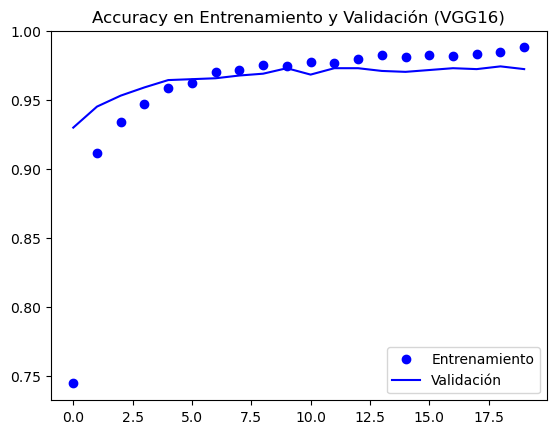

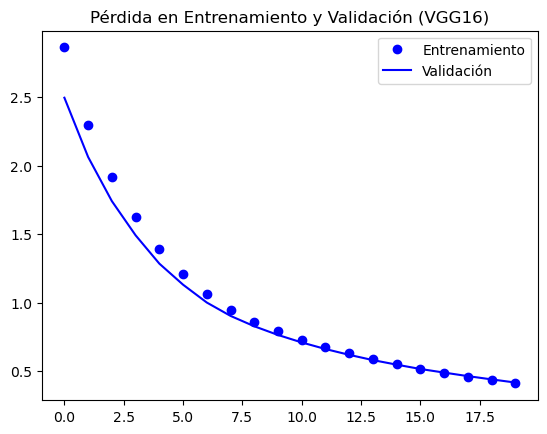

In [15]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history.history['acc']
val_acc = history.history['val_acc']
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación (VGG16)')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación (VGG16)')
plt.legend()

plt.show()

We have a very good accuracy, 97.5% on the test set.
Now we try the same procedure on the other 2 convolutional bases.

## MobiletNet

In [16]:
train_features2, train_labels2 = extract_features(conv_base2,train_generator, train_generator.n,feature_map_size2)
validation_features2, validation_labels2 = extract_features(conv_base2,val_generator, val_generator.n,feature_map_size2)

1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 64ms/step


/Users/antoniopace/anaconda3/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


In [17]:
train_features2 = np.reshape(train_features2, (train_generator.n, 5 * 5 * 1024))
validation_features2 = np.reshape(validation_features2, (val_generator.n, 5 * 5 * 1024))

In [105]:
model2 = models.Sequential()

model2.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1),input_dim = 5 * 5 * 1024))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history2 = model2.fit(train_features2, train_labels2,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features2, validation_labels2))

/Users/antoniopace/anaconda3/lib/python3.11/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
227/227 [==============================] - 2s 8ms/step - loss: 204.6610 - acc: 0.9433 - val_loss: 160.1040 - val_acc: 0.9815
Epoch 2/20
227/227 [==============================] - 2s 7ms/step - loss: 124.2038 - acc: 0.9883 - val_loss: 92.0227 - val_acc: 0.9914
Epoch 3/20
227/227 [==============================] - 2s 7ms/step - loss: 67.7457 - acc: 0.9923 - val_loss: 46.6968 - val_acc: 0.9947
Epoch 4/20
227/227 [==============================] - 2s 7ms/step - loss: 31.8543 - acc: 0.9947 - val_loss: 19.5517 - val_acc: 0.9940
Epoch 5/20
227/227 [==============================] - 2s 7ms/step - loss: 11.8522 - acc: 0.9954 - val_loss: 5.9392 - val_acc: 0.9947
Epoch 6/20
227/227 [==============================] - 2s 7ms/step - loss: 2.9446 - acc: 0.9967 - val_loss: 1.0231 - val_acc: 0.9960
Epoch 7/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4229 - acc: 0.9960 - val_loss: 0.1635 - val_acc: 0.9954
Epoch 8/20
227/227 [==============================] - 2s 7ms/ste

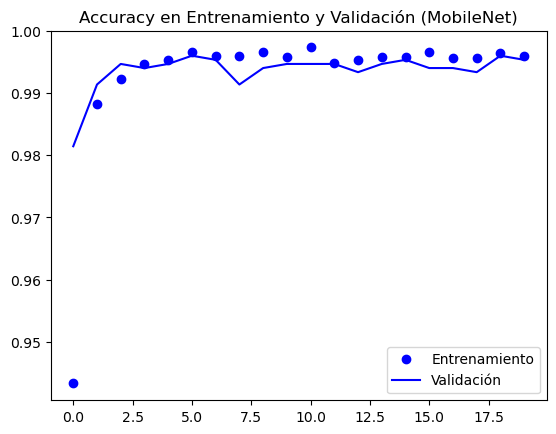

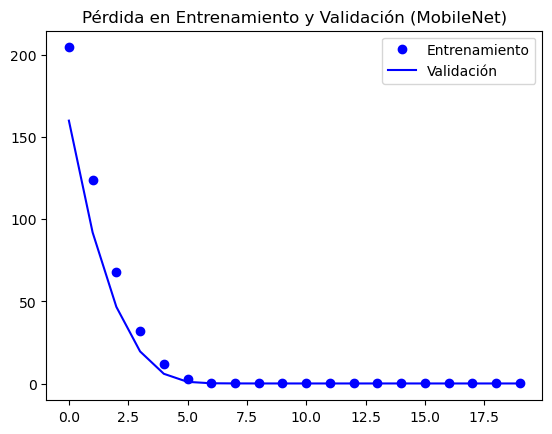

In [106]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history2.history['acc']
val_acc = history2.history['val_acc']
ent_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación (MobileNet)')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación (MobileNet)')
plt.legend()

plt.show()

With MobileNet we have a better accuracy.

In [141]:
model2.evaluate(validation_features2,validation_labels2)

48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - acc: 0.9954


[0.04371936246752739, 0.995364248752594]

## Xception

In [20]:
train_features3, train_labels3 = extract_features(conv_base3,train_generator, train_generator.n,feature_map_size3)
validation_features3, validation_labels3 = extract_features(conv_base3,val_generator, val_generator.n,feature_map_size3)

1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 162ms/step


In [21]:
train_features3 = np.reshape(train_features3, (train_generator.n, 5 * 5 * 2048))
validation_features3 = np.reshape(validation_features3, (val_generator.n, 5 * 5 * 2048))

In [22]:
model3 = models.Sequential()

model3.add(layers.Dense(64, activation='relu',input_dim = 5 * 5 * 2048))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history3 = model3.fit(train_features3, train_labels3,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features3, validation_labels3))

Epoch 1/20
227/227 [==============================] - 2s 8ms/step - loss: 0.0965 - acc: 0.9680 - val_loss: 0.0416 - val_acc: 0.9881
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0366 - acc: 0.9905 - val_loss: 0.0488 - val_acc: 0.9854
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0296 - acc: 0.9916 - val_loss: 0.0339 - val_acc: 0.9901
Epoch 4/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0274 - acc: 0.9936 - val_loss: 0.0343 - val_acc: 0.9907
Epoch 5/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0250 - acc: 0.9947 - val_loss: 0.0353 - val_acc: 0.9901
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0207 - acc: 0.9951 - val_loss: 0.0350 - val_acc: 0.9901
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0188 - acc: 0.9967 - val_loss: 0.0361 - val_acc: 0.9894
Epoch 8/20
227/227 [==============================] - 1s 6ms/step - loss: 0.

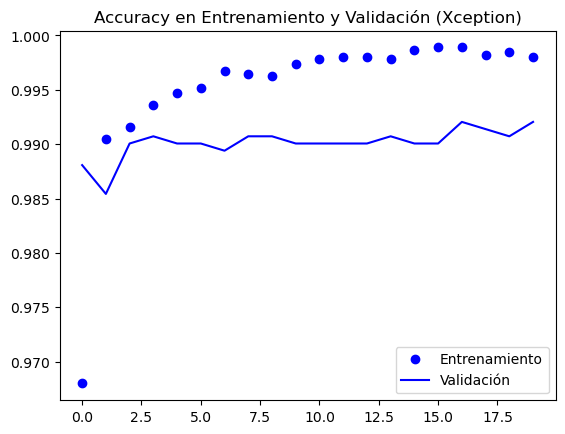

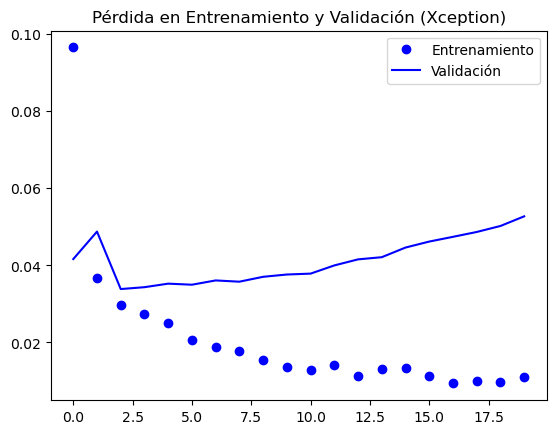

In [23]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history3.history['acc']
val_acc = history3.history['val_acc']
ent_loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación (Xception)')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación (Xception)')
plt.legend()

plt.show()

Here I prefer MobileNet, because is the one with highest accuracy and lowest difference between validation and training set values.

## Fine tuning

We can do some data augmentation for avoiding overfitting

In [143]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen_aug = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=batch_size,
    class_mode='binary'
)


Found 4531 images belonging to 2 classes.


In [116]:
conv_base2.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 10, 10, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 10, 10, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 10, 10, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 10, 10, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 10, 10, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 10, 10, 512)       262144    
                                                                 
 conv_pw_9

We try the fine tuning from 'conv_pw_12'.

In [144]:
conv_base2.trainable = True

set_trainable = False
for layer in conv_base2.layers:
    if layer.name == 'conv_pw_12':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [155]:
model4 = models.Sequential()

model4.add(conv_base2)
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history4 = model4.fit(train_generator_aug, steps_per_epoch=len(train_generator_aug),
                    epochs=10,
                    batch_size=batch_size,
                    validation_steps=len(val_generator),
                    validation_data=val_generator)

Epoch 1/10


2024-01-23 12:20:01.430789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - ETA: 0s - loss: 208.8248 - acc: 0.9038

2024-01-23 12:20:25.065360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 29s 125ms/step - loss: 208.8248 - acc: 0.9038 - val_loss: 166.0715 - val_acc: 0.9914
Epoch 2/10
227/227 [==============================] - 28s 122ms/step - loss: 130.9467 - acc: 0.9642 - val_loss: 99.0042 - val_acc: 0.9934
Epoch 3/10
227/227 [==============================] - 27s 119ms/step - loss: 74.3586 - acc: 0.9757 - val_loss: 52.7145 - val_acc: 0.9921
Epoch 4/10
227/227 [==============================] - 27s 119ms/step - loss: 37.1155 - acc: 0.9817 - val_loss: 24.0683 - val_acc: 0.9934
Epoch 5/10
227/227 [==============================] - 27s 119ms/step - loss: 15.5580 - acc: 0.9852 - val_loss: 8.6763 - val_acc: 0.9927
Epoch 6/10
227/227 [==============================] - 27s 119ms/step - loss: 5.1819 - acc: 0.9837 - val_loss: 2.5799 - val_acc: 0.9927
Epoch 7/10
227/227 [==============================] - 27s 119ms/step - loss: 1.4448 - acc: 0.9868 - val_loss: 0.6621 - val_acc: 0.9934
Epoch 8/10
227/227 [==============================] - 

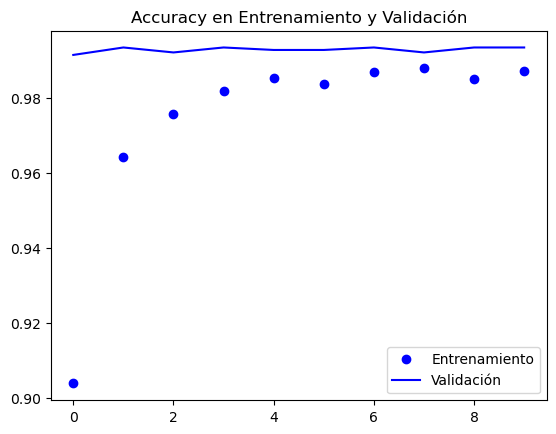

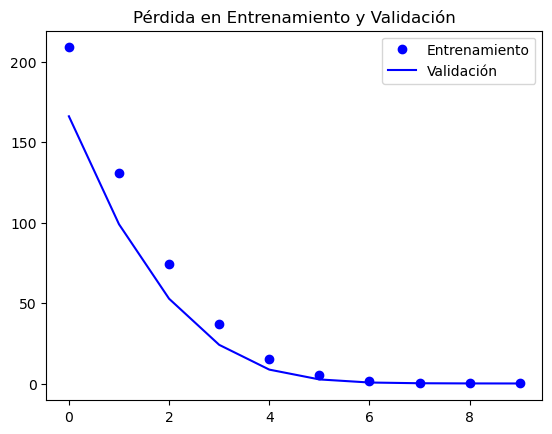

In [156]:
ent_acc = history4.history['acc']
val_acc = history4.history['val_acc']
ent_loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

In [157]:
model4.evaluate(test_generator)

 2/76 [..............................] - ETA: 5s - loss: 0.0934 - acc: 0.9750

2024-01-23 12:24:35.371767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


76/76 [==============================] - 6s 73ms/step - loss: 0.0665 - acc: 0.9901


[0.06653869897127151, 0.9900793433189392]

In [194]:
model4.save('mask_finetuning.h5')

Now let's try to train the convolutional base from 'conv_pw_8''.

In [183]:
set_trainable = False
for layer in conv_base2.layers:
    if layer.name == 'conv_pw_6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [184]:
model5 = models.Sequential()

model5.add(conv_base2)
model5.add(layers.Flatten())
model5.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history5 = model5.fit(train_generator_aug, steps_per_epoch=len(train_generator_aug),
                    epochs=10,
                    batch_size=batch_size,
                    validation_steps=len(val_generator),
                    validation_data=val_generator)

Epoch 1/10


/Users/antoniopace/anaconda3/lib/python3.11/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-01-23 12:42:38.557695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - ETA: 0s - loss: 207.7442 - acc: 0.9243

/Users/antoniopace/anaconda3/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2024-01-23 12:43:15.493057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 42s 182ms/step - loss: 207.7442 - acc: 0.9243 - val_loss: 164.2448 - val_acc: 0.9960
Epoch 2/10
227/227 [==============================] - 40s 176ms/step - loss: 128.3732 - acc: 0.9786 - val_loss: 96.1712 - val_acc: 0.9954
Epoch 3/10
227/227 [==============================] - 40s 174ms/step - loss: 71.6574 - acc: 0.9823 - val_loss: 50.1582 - val_acc: 0.9954
Epoch 4/10
227/227 [==============================] - 40s 177ms/step - loss: 34.8135 - acc: 0.9874 - val_loss: 21.9498 - val_acc: 0.9960
Epoch 5/10
227/227 [==============================] - 40s 176ms/step - loss: 13.7866 - acc: 0.9894 - val_loss: 7.3979 - val_acc: 0.9954
Epoch 6/10
227/227 [==============================] - 40s 177ms/step - loss: 4.0233 - acc: 0.9912 - val_loss: 1.6603 - val_acc: 0.9954
Epoch 7/10
227/227 [==============================] - 40s 175ms/step - loss: 0.7959 - acc: 0.9916 - val_loss: 0.2730 - val_acc: 0.9947
Epoch 8/10
227/227 [==============================] - 

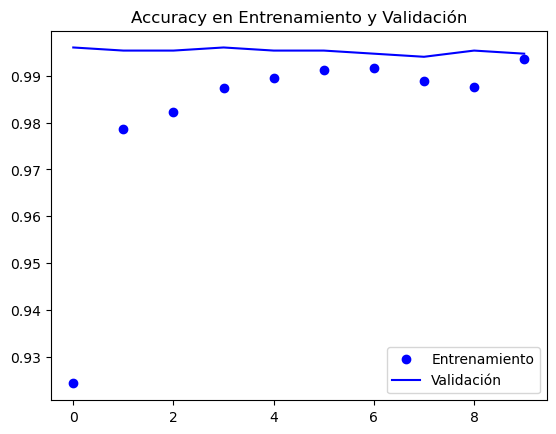

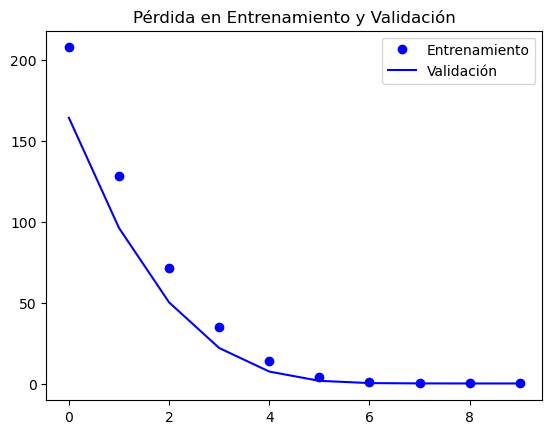

In [185]:
ent_acc = history5.history['acc']
val_acc = history5.history['val_acc']
ent_loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

In [186]:
model5.evaluate(test_generator)

 2/76 [..............................] - ETA: 4s - loss: 0.0174 - acc: 1.0000

2024-01-23 12:49:38.424253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


76/76 [==============================] - 6s 73ms/step - loss: 0.0290 - acc: 0.9954


[0.02903919853270054, 0.9953703880310059]

In [193]:
model5.save('mask_finetuning2.h5')

With fine tuning we reach a >99% accuracy on the test set which is perfect. Unfreezing more layers is more convenient because the dataset is different, containing only images of people with or without mask, also if the difference in accuracy is small, just 0.5%

Now we create a second test generator with the suggested dataset from kaggle. We use all the dataset for testing. This dataset is considerately bigger than the first one.

In [166]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen2 = ImageDataGenerator(rescale=1./255)
ds_dir = 'data2'

test_generator2 = train_datagen.flow_from_directory(
    ds_dir,
    target_size=(160, 160),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 20347 images belonging to 2 classes.


In [190]:
test_generator2.class_indices

{'With_Mask': 0, 'Without_Mask': 1}

## 5. Evaluación de los modelos sobre conjunto de test, y sobre otro dataset para face mask detection. Evaluación también sobre imágenes de webcam/Internet.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def show_metrics(model, data_generator, model_name):
    print(f"{'='*40} {model_name} {'='*40}")
    
    predictions = model.predict(data_generator)

    y_pred = (predictions > 0.5).astype(int)

    acc = accuracy_score(data_generator.classes, y_pred)
    conf_matrix = confusion_matrix(data_generator.classes, y_pred)
    report = classification_report(data_generator.classes, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)


Here i had problems because index of the generator were shuffled and with predict I didn't get the right results. I found that .reset() should solve the issues

In [187]:
train_generator.reset()
test_generator.reset()
test_generator2.reset()

In [191]:
show_metrics(model4,test_generator,"first dataset")

======================================== first dataset ========================================
 1/76 [..............................] - ETA: 10s

2024-01-23 12:54:48.722898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


76/76 [==============================] - 6s 73ms/step
Accuracy: 0.9914
Confusion Matrix:
 [[744   1]
 [ 12 755]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       745
           1       1.00      0.98      0.99       767

    accuracy                           0.99      1512
   macro avg       0.99      0.99      0.99      1512
weighted avg       0.99      0.99      0.99      1512



In [192]:
show_metrics(model4,test_generator2,"second dataset")

======================================== second dataset ========================================
   2/1018 [..............................] - ETA: 1:06

2024-01-23 12:54:54.440453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1018/1018 [==============================] - 68s 67ms/step
Accuracy: 0.9909
Confusion Matrix:
 [[ 9966   141]
 [   45 10195]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     10107
           1       0.99      1.00      0.99     10240

    accuracy                           0.99     20347
   macro avg       0.99      0.99      0.99     20347
weighted avg       0.99      0.99      0.99     20347



In [188]:
show_metrics(model5,test_generator,"first dataset")

======================================== first dataset ========================================


2024-01-23 12:51:11.861877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


76/76 [==============================] - 6s 74ms/step
Accuracy: 0.9954
Confusion Matrix:
 [[744   1]
 [  6 761]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       745
           1       1.00      0.99      1.00       767

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



In [189]:
show_metrics(model5,test_generator2,"second dataset")

======================================== second dataset ========================================
   2/1018 [..............................] - ETA: 1:03

2024-01-23 12:51:17.774531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1018/1018 [==============================] - 69s 68ms/step
Accuracy: 0.9883
Confusion Matrix:
 [[ 9889   218]
 [   20 10220]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     10107
           1       0.98      1.00      0.99     10240

    accuracy                           0.99     20347
   macro avg       0.99      0.99      0.99     20347
weighted avg       0.99      0.99      0.99     20347



Also with the second dataset that we used only for testing, the results are almost perfect with 99% of F1-score.

Now try to classify some images found on the web.

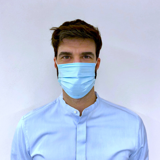

In [180]:
from PIL import Image
import base64
from numpy import asarray
import io
import time

mask_im = Image.open("mask.jpg") 
mask_im = mask_im.resize((160,160))
mask_im

In [181]:
im = np.asarray(mask_im) / 255
result = 'with_mask' if model5.predict(np.array([im])) <= 0.5 else 'without_mask'
result

1/1 [==============================] - 0s 184ms/step


'with_mask'

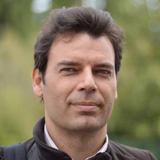

In [179]:
no_mask_im = Image.open("no_mask.jpg") 
no_mask_im = mask_im.resize((160,160))
no_mask_im

In [182]:
im = np.asarray(no_mask_im) / 255
result = 'with_mask' if model5.predict(np.array([im])) <= 0.5 else 'without_mask'
result

1/1 [==============================] - 0s 25ms/step


'without_mask'

Images are labeled correctly